In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

pd.set_option("display.float_format", "{:,.2f}".format)

In [6]:
import os

os.chdir(r"C:\Users\mutha\Downloads")

df = pd.read_excel("Online Retail Data Set.xlsx")

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,"17,850.00",United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,"17,850.00",United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [8]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,"541,909.00",541909,"541,909.00","406,829.00"
mean,9.55,2011-07-04 13:34:57.156386048,4.61,"15,287.69"
min,"-80,995.00",2010-12-01 08:26:00,"-11,062.06","12,346.00"
25%,1.00,2011-03-28 11:34:00,1.25,"13,953.00"
50%,3.00,2011-07-19 17:17:00,2.08,"15,152.00"
75%,10.00,2011-10-19 11:27:00,4.13,"16,791.00"
max,"80,995.00",2011-12-09 12:50:00,"38,970.00","18,287.00"
std,218.08,NaN,96.76,"1,713.60"


In [10]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [11]:
df['Country'] = df['Country'].astype(str)
df['Description'] = df['Description'].astype(str)

In [18]:
from sqlalchemy import create_engine

In [ ]:
# Enforce types
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Country'] = df['Country'].astype(str)
df['Description'] = df['Description'].astype(str)

# PostgreSQL connection
engine = create_engine(
    "postgresql://avnadmin:password-muthamikevin80-30b7.k.aivencloud.com:23351/defaultdb",
    connect_args={"sslmode": "require"}
)

# Load into PostgreSQL
df.to_sql(
    "retail_raw",
    engine,
    schema="retail",  
    if_exists="replace",
    index=False
)

print("Raw data loaded successfully")

Raw data loaded successfully


In [25]:
from sqlalchemy import text

with engine.connect() as conn:
    df = pd.read_sql(text("SELECT * FROM retail.retail_raw"), conn)


In [27]:
df.shape

(531285, 8)

In [30]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["InvoiceNo"] = df["InvoiceNo"].astype(str)
df["Country"] = df["Country"].astype(str)
df["Description"] = df["Description"].astype(str)

# 1. Quantity validation (remove returns & invalid quantities)
df = df[df["Quantity"] > 0]

# 2. Unit price validation (remove negative prices)
df = df[df["UnitPrice"] >= 0]

# 3. Remove invoice cancellations (InvoiceNo starting with 'C')
df = df[~df["InvoiceNo"].str.startswith("C")]

# 4. Drop rows with missing CustomerID
df = df.dropna(subset=["CustomerID"])

# 5. Remove duplicate records
df = df.drop_duplicates()

# 6. Feature engineering
df["Revenue"] = df["Quantity"] * df["UnitPrice"]

df["Year"] = df["InvoiceDate"].dt.year
df["Month"] = df["InvoiceDate"].dt.month
df["Day"] = df["InvoiceDate"].dt.day

print("Cleaned dataset shape:", df.shape)
df.head()

Cleaned dataset shape: (392732, 12)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Year,Month,Day
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,"17,850.00",United Kingdom,15.30,2010,12,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom,20.34,2010,12,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,"17,850.00",United Kingdom,22.00,2010,12,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom,20.34,2010,12,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom,20.34,2010,12,1


In [31]:
df.to_sql(
    "clean_retail",
    engine,
    schema="retail",
    if_exists="replace",
    index=False
)

print("Cleaned data stored successfully")


Cleaned data stored successfully


In [34]:
import pandas as pd
from sqlalchemy import text

with engine.connect() as conn:
    clean_df = pd.read_sql(
        text("SELECT * FROM retail.clean_retail"),
        conn
    )

clean_df.shape


(392732, 12)

In [35]:
sales_2011 = clean_df[clean_df["Year"] == 2011]

monthly_revenue_2011 = (
    sales_2011
    .groupby("Month")["Revenue"]
    .sum()
    .reset_index()
    .sort_values("Month")
)

monthly_revenue_2011


,Month,Revenue
0,1,"568,101.31"
1,2,"446,084.92"
2,3,"594,081.76"
3,4,"468,374.33"
4,5,"677,355.15"
5,6,"660,046.05"
6,7,"598,962.90"
7,8,"644,051.04"
8,9,"950,690.20"
9,10,"1,035,642.45"


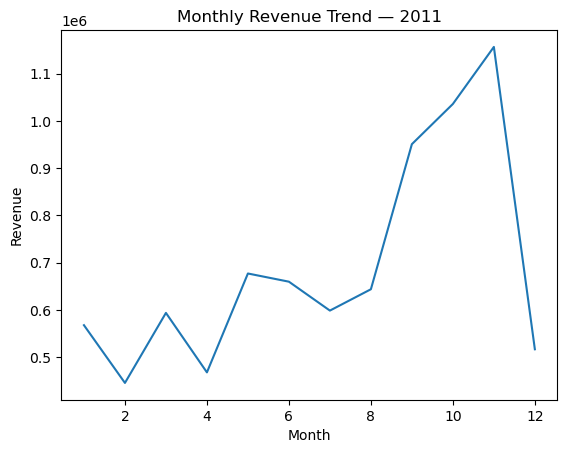

In [36]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(
    monthly_revenue_2011["Month"],
    monthly_revenue_2011["Revenue"]
)
plt.title("Monthly Revenue Trend — 2011")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.show()


In [37]:
country_performance = (
    clean_df[clean_df["Country"] != "United Kingdom"]
    .groupby("Country")
    .agg(
        TotalRevenue=("Revenue", "sum"),
        TotalQuantity=("Quantity", "sum")
    )
    .sort_values("TotalRevenue", ascending=False)
    .head(10)
)

country_performance


,TotalRevenue,TotalQuantity
Country,,
Netherlands,"285,446.34",200937
EIRE,"265,262.46",140383
Germany,"228,678.40",119156
France,"208,934.31",111429
Australia,"138,453.81",84199
Spain,"61,558.56",27944
Switzerland,"56,443.95",30083
Belgium,"41,196.34",23237
Sweden,"38,367.83",36078


In [38]:
top_customers = (
    clean_df
    .groupby("CustomerID")["Revenue"]
    .sum()
    .reset_index()
    .sort_values("Revenue", ascending=False)
    .head(10)
)

top_customers


,CustomerID,Revenue
1690,"14,646.00","280,206.02"
4202,"18,102.00","259,657.30"
3729,"17,450.00","194,390.79"
3009,"16,446.00","168,472.50"
1880,"14,911.00","143,711.17"
55,"12,415.00","124,914.53"
1334,"14,156.00","117,210.08"
3772,"17,511.00","91,062.38"
2703,"16,029.00","80,850.84"
0,"12,346.00","77,183.60"


In [39]:
global_demand = (
    clean_df[clean_df["Country"] != "United Kingdom"]
    .groupby("Country")["Quantity"]
    .sum()
    .reset_index()
    .sort_values("Quantity", ascending=False)
)

global_demand.head(10)


,Country,Quantity
23,Netherlands,200937
10,EIRE,140383
14,Germany,119156
13,France,111429
0,Australia,84199
31,Sweden,36078
32,Switzerland,30083
30,Spain,27944
19,Japan,26016
3,Belgium,23237
